In [363]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [364]:
#### Preprocecing ###

In [365]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [366]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [367]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [368]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [369]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [370]:
### Data Preparation ###

In [371]:
country = 'Japan'
S0 = confirmed[country].values
R0 = recovered[country].values
D0 = death[country].values
P = 12000_0000
iter=2000

In [372]:
S0

array([   2,    2,    2,    2,    4,    4,    7,    7,   11,   15,   20,
         20,   20,   22,   22,   22,   25,   25,   26,   26,   26,   28,
         28,   29,   43,   59,   66,   74,   84,   94,  105,  122,  147,
        159,  170,  189,  214,  228,  241,  256,  274,  293,  331,  360,
        420,  461,  502,  511,  581,  639,  639,  701,  773,  839,  839,
        878,  889,  924,  963, 1007, 1101, 1128, 1193, 1307, 1387, 1468,
       1693, 1866, 1866, 1953, 2178, 2495, 2617, 3139, 3139, 3654, 3906,
       4257, 4667, 5530, 6005, 6748])

In [373]:
data = {'T': S0.shape[0], 'P': P, 'S0': S0, 'R0': R0, 'D0': D0}

In [374]:
### Model ###

In [375]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b209831c01eddeb39982262f67ebe858 NOW.


In [376]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [377]:
### Visualization functions ###

In [378]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [379]:
def simulate(init_inf, b0, b1, theta_b, b_date, q1, theta_q, q_date, a, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q1 * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = 0.005 * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=horizon+1, freq='D'))
    return data

In [380]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for i in range(n):
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [381]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [382]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [383]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


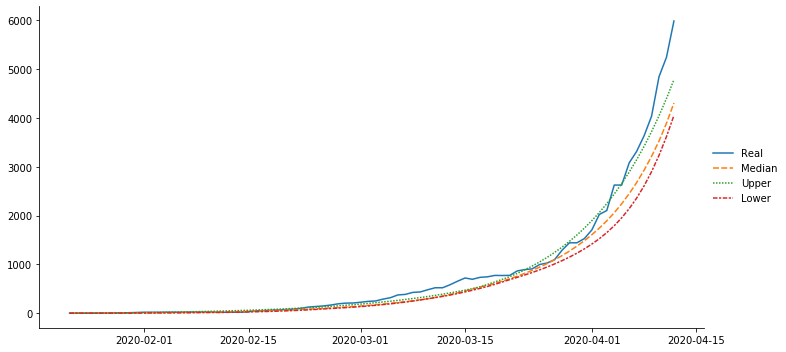

In [384]:
draw(I0, real=(confirmed-recovered)[country])

In [385]:
S.median(axis=1)[pd.to_datetime('2020-04-12')]

418209.87939667027

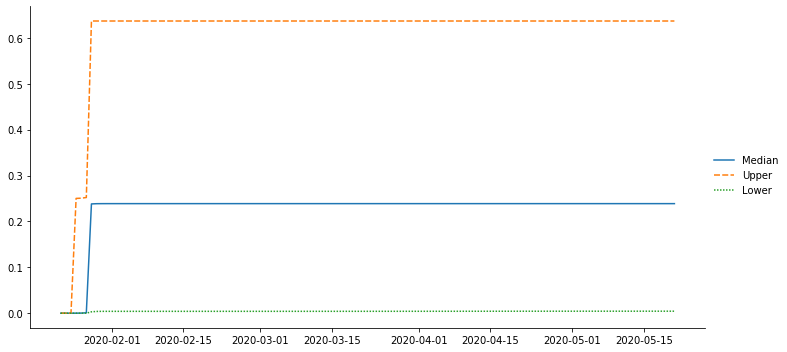

In [386]:
draw(q)

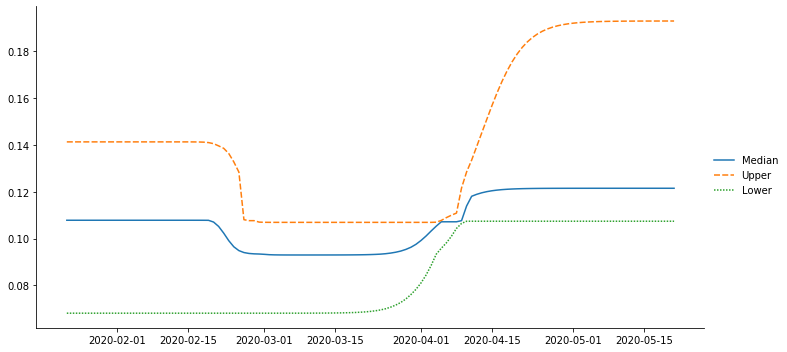

In [387]:
draw(b)

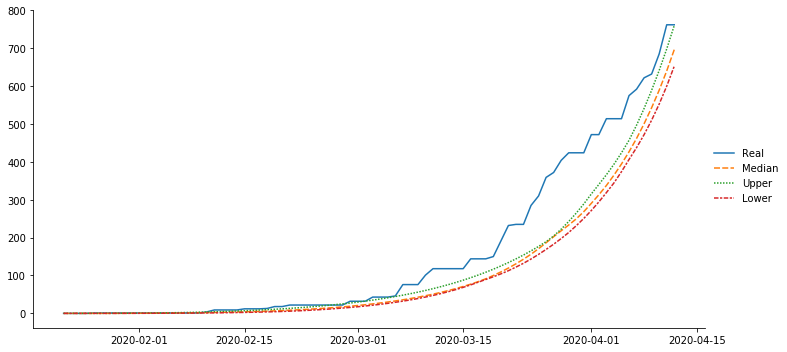

In [388]:
draw(R0, real=recovered[country])

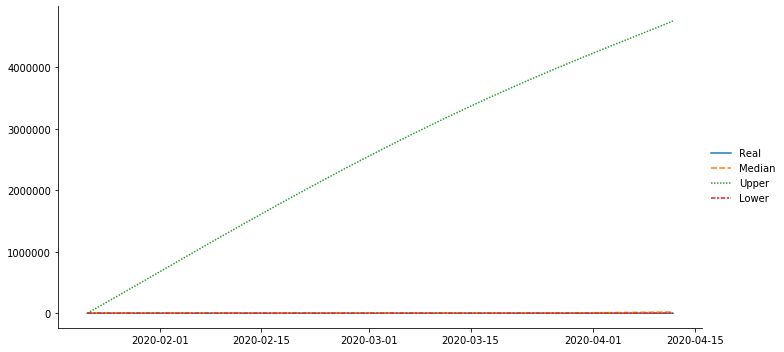

In [389]:
draw(D, real=death[country])

In [390]:
fit

Inference for Stan model: anon_model_b209831c01eddeb39982262f67ebe858.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf_alpha  3.3e6   4.0e6  5.8e6  13.68 937.92  3.5e4  5.4e6  1.7e7      2   5.45
init_inf_beta   8.4e4   1.0e5  1.5e5 4.3e-5   6.08  89.79  1.3e5  4.3e5      2   5.44
init_inf        1.4e7   1.7e7  2.4e7   1.57  17.08 168.24  2.9e7  5.7e7      2  52.56
b0_alpha        2.8e5   3.0e5  4.2e5   0.21  25.22  4.4e4  6.1e5  1.0e6      2 213.45
b0_beta         1.9e6   2.1e6  2.9e6   5.46 642.24  3.2e5  4.3e6  7.0e6      2 209.84
b0                0.1    0.03   0.04   0.04   0.06   0.11   0.14   0.14      2   63.5
b1_alpha        3.0e7   3.6e7  5.4e7   4.38   9.86  5.6e4  2.0e7  1.5e8      2   3.76
b1_beta         2.8e8   3.4e8  5.1e8   8.96   58.5  5.1e5  1.8e8  1.5e9      2   3.78
b1               0.18    0.08   0.12 

In [391]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [392]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

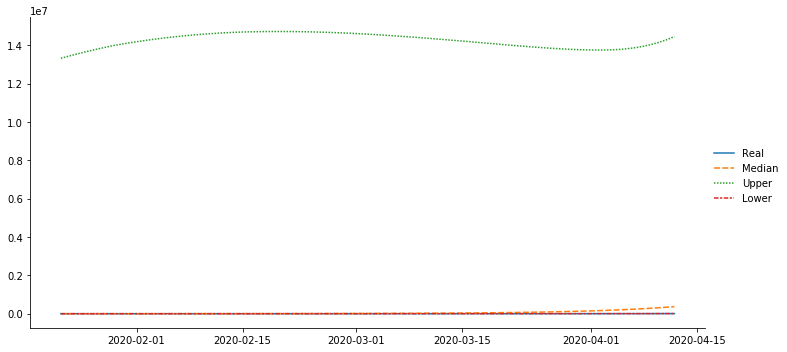

In [393]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

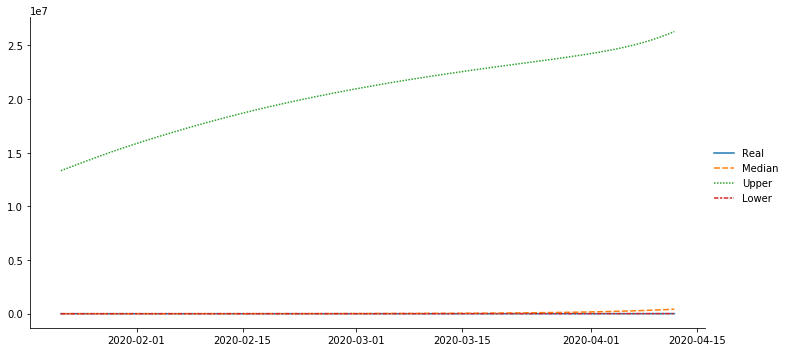

In [394]:
draw(cumulative, real=confirmed[country])

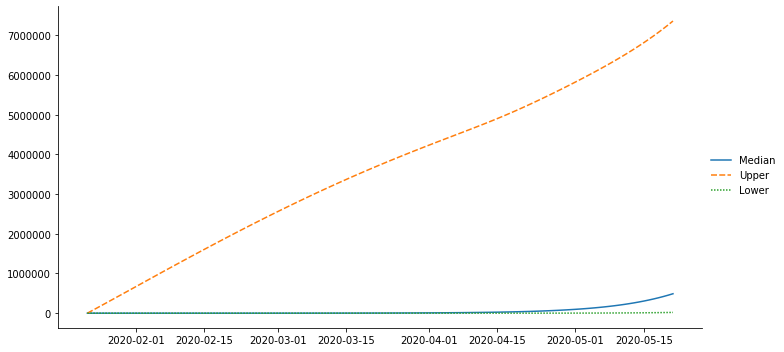

In [395]:
draw(D)